In [10]:
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
from keras.layers import Input, Dense, Lambda
from keras.layers import *
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
train_data = mnist.train.images
train_labels = mnist.train.labels
n_x = train_data.shape[1] # 784
n_y = train_labels.shape[1] # 10
n_z = 2
n_epoch = 20
m = 50 # batch size

In [11]:
# Encoder Q(z/X, c)
X = Input(shape=(n_x,))
c = Input(shape=(n_y,))
# merge label with data
X_c = concatenate([X, c])
#inputs = merge([X, c], mode='concat', concat_axis=1)

# Hidden layer of the encoder
h_q = Dense(512, activation='relu')(X_c)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

In [12]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(n_z,), mean=0.)
    return mu + K.exp(log_sigma / 2) * eps


# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])
# concatenate z with label
z_c = concatenate([z, c], axis=1)

In [13]:
# P(X|z) -- decoder
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z_c)
output = decoder_out(h_p)

In [77]:
X_c

<tf.Tensor 'concatenate_8/concat:0' shape=(?, 794) dtype=float32>

In [14]:
# Overall CVAE model, for reconstruction and training
vae = Model([X, c], output)

In [15]:
# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the representative of the gaussian
encoder = Model([X, c], mu)

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z + 10,)) # concatenate label with z
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [16]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl

In [17]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit([train_data, train_labels], train_data, batch_size=m, epoch=n_epoch)

/Users/bnjasim/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


Epoch 1/20
55000/55000 [==============================] - 31s - loss: 163.3871    
Epoch 2/20
55000/55000 [==============================] - 30s - loss: 141.8519    
Epoch 3/20
55000/55000 [==============================] - 29s - loss: 138.8338    
Epoch 4/20
55000/55000 [==============================] - 29s - loss: 137.2457    
Epoch 5/20
55000/55000 [==============================] - 29s - loss: 136.2031    
Epoch 6/20
55000/55000 [==============================] - 30s - loss: 135.3805    
Epoch 7/20
55000/55000 [==============================] - 29s - loss: 134.8799    
Epoch 8/20
55000/55000 [==============================] - 30s - loss: 134.1413    
Epoch 9/20
55000/55000 [==============================] - 30s - loss: 133.7442    
Epoch 10/20
55000/55000 [==============================] - 30s - loss: 133.3653    
Epoch 11/20
55000/55000 [==============================] - 29s - loss: 133.0822    
Epoch 12/20
55000/55000 [==============================] - 28s - loss: 132.7628    
E

In [18]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 784)           0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 10)            0                                            
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 794)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 512)           407040                                       
___________________________________________________________________________________________

### Recreate a Digit

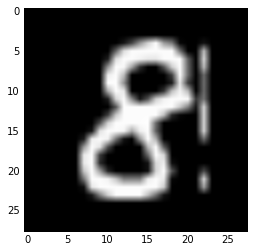

In [34]:
index = 9
x = train_data[index]
y = train_labels[index]
plt.imshow(x.reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.show()

[[-0.67493427  0.17491595]]


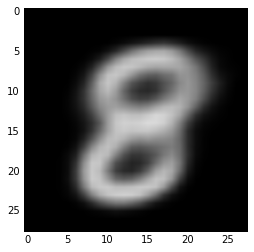

In [35]:
z_latent = encoder.predict([x.reshape(1,784), y.reshape(1,10)])
print z_latent
z_concat = np.concatenate([z_latent.flatten(), y]).reshape(1,12)
pred = decoder.predict(z_concat)

plt.imshow(pred.reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.show()

## Generate New Digits

[[-0.24690366 -1.54674959  0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.        ]]


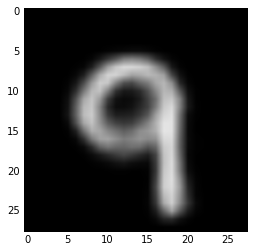

In [349]:
# sample from z
digit = 9
a = np.zeros(10)
a[digit] = 1
z = np.array([np.random.normal(), np.random.normal()]).reshape([1,2])
z_concat = np.concatenate([z.flatten(), a]).reshape(1,12)
print z_concat
pred = decoder.predict(z_concat)

plt.imshow(pred.reshape(28,28), cmap='gray', vmin=0, vmax=1)
plt.show()

In [163]:
np.sum(pred)

127.34616

## Plot the latent space

Each of the conditional distributions $P(z/c)$ is normally distributed

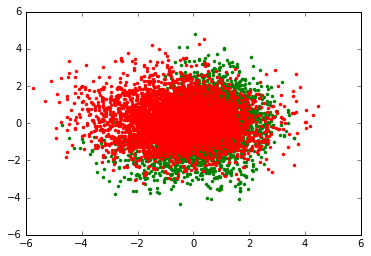

In [346]:
digit = 9
a = np.zeros(10)
a[digit] = 1
labels = np.where(train_labels==1.0)[1]
digit_data = train_data[labels == digit]
# Obtain the latent representations
temp = np.tile(a, (digit_data.shape[0], 1))
z_digit = encoder.predict([digit_data, temp])
plt.plot(z_digit[:,0], z_digit[:,1], '.g')

# another digit
digit = 0
a = np.zeros(10)
a[digit] = 1
labels = np.where(train_labels==1.0)[1]
digit_data = train_data[labels == digit]
# Obtain the latent representations
temp = np.tile(a, (digit_data.shape[0], 1))
z_digit = encoder.predict([digit_data, temp])
plt.plot(z_digit[:,0], z_digit[:,1], '.r')

plt.show()

In [342]:
temp = np.tile(a, (digit_data.shape[0], 1))

In [343]:
temp.shape

(5454, 10)